In [1]:
%pylab inline --no-import-all

/Users/MeghanFrate/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Populating the interactive namespace from numpy and matplotlib


In [2]:
import george
from george.kernels import MyDijetKernelSimp


import math
import time
import numpy as np
import scipy.stats as ss
import scipy.special as ssp
import scipy.optimize as op
from iminuit import Minuit

import ROOT as r
from rootpy.plotting import Hist, Hist2D, Legend, Canvas
import rootpy.plotting.root2matplotlib as rplt

## Inputs

In [3]:
#Full bin centers (xvalO), counts (yvalO), bin width (xerrO), and bin low edges (xlowO) from ATLAS
xvalO = np.load("newoutputs/xvalO.npy")
yvalO = np.load("newoutputs/yvalO.npy")
xerrO = np.load("newoutputs/xerrO.npy")
xlowO = np.load("newoutputs/xlowO.npy")

#Same, but with bins with zero counts removed. GP fits better without zero counts
xval = np.load("newoutputs/xval.npy")
yval = np.load("newoutputs/yval.npy")
xerr = np.load("newoutputs/xerr.npy")

#10000 toys - created from 5 parameter fit to data with Poisson noise
toyList = np.load("newoutputs/toyList.npy")
fixedHyperparams = np.load("newoutputs/fixedHyperparams.npy")

# Gaussian signals
sigToys = np.load("newoutputs/signalToys.npy")
sigToysO = np.load("newoutputs/signalToysO.npy")
standardParamSets = [(2000,2000,250), (700, 2500, 250), (250, 3000, 250), (125, 3500, 250), (70, 4000, 250), 
             (40, 4500, 250), (25, 5000, 250), (15,5500, 250), (10, 6000,250)]

### Gaussian Signal

In [4]:
def sig_model(x, N=1e5, mass=2000., width=100., xErr=xerr):
    return N*(np.exp(-(x-mass)**2/2/width/width)/np.sqrt(2*np.pi)/width)*xErr

### 3 and 5 parameters fit function

In [5]:
def model_3param(t, params, xErr=xerr): 
    p0, p1, p2 = params
    sqrts = 13000.
    return (p0 * ((1.-t/sqrts)**p1) * (t/sqrts)**(p2))*(xErr) 
def model_5param(t, params, xErr=xerr): 
    p0, p1, p2, p3, p4 = params
    sqrts = 13000.
    return (p0 * ((1.-t/sqrts)**p1) * (t/sqrts)**(p2+p3*np.log(t/sqrts)+p4*np.log(t/sqrts)**2))*(xErr)

### Calculate z values and chi squared

In [6]:
def calcSignificance(Data, Bkg):
    pvals = []
    zvals = []
    chi2 = 0
    for i, nD in enumerate(Data):
        nB = Bkg[i]
        if nD != 0:
            if nB > nD:
                pval = 1.-ssp.gammainc(nD+1.,nB)
            else:
                pval = ssp.gammainc(nD,nB)
            prob = 1-2*pval
            if prob > -1 and prob < 1:
                zval = math.sqrt(2.)*ssp.erfinv(prob)
            else:
                zval = np.inf
            if zval > 100: zval = 20
            if zval < 0: zval = 0
            if (nD < nB): zval = -zval
        else: zval = 0
            
        zvals.append(zval)
        chi2 += ((nD - nB) ** 2 / abs(nB)) 
    return zvals, chi2

### Poisson likelihood

In [7]:
def simpleLogPoisson(x, par):
    if x < 0: 
        return np.inf
    elif (x == 0): return -1.*par
    else:
        lnpoisson = x*np.log(par)-par-ssp.gammaln(x+1.)
        return lnpoisson

### Poisson log likelihood

In [8]:
def removeZeros(data):
    indices = [i for i, x in enumerate(data) if x == 0]
    newylist=[]
    newxlist=[]
    newxerrlist=[]
    for k in range(len(data)):
        if k not in indices:
            newylist.append(data[k])
            newxlist.append(xvalO[k])
            newxerrlist.append(xerrO[k])
    return np.array(newylist), np.array(newxlist), np.array(newxerrlist)

### Minimize poisson likelihood using minuit to fit 3 parameter fit function parameters and Gaussian signal parameters

In [9]:
class logLike_3ff_fitsig:
    def __init__(self, x, y, xe):
        self.x = x
        self.y = y
        self.xe = xe
    def __call__(self, p0, p1, p2, Num, mu, sigma):
        params = p0, p1, p2
        bkgFunc = model_3param(self.x, params, self.xe)  
        signal = sig_model(self.x, Num, mu, sigma, self.xe)
        logL = 0
        for ibin in range(len(self.y)):
            data = self.y[ibin]
            bkg = bkgFunc[ibin] 
            sig = signal[ibin]
            logL += -simpleLogPoisson(data, bkg+sig)
        try:
            logL
            return logL
        except:
            return np.inf

def fit_3ff_fitsig(lnprob, Print = True):
    bestval = np.inf
    bestargs = (0., 0., 0., 0., 0., 0.)
    passedFit = False
    numRetries = 0
    for i in range(100):
        init0 = np.random.random() * 1.
        init1 = np.random.random() * 8.
        init2 = np.random.random() * 6.
        init3 = np.random.random() * 5000.
        init4 = np.random.random() * 4000.
        init5 = np.random.random() * 200.
        m = Minuit(lnprob, throw_nan = False, pedantic = False, print_level = 0, errordef = 0.5,
                  p0 = init0, p1 = init1, p2 = init2, Num = init3, mu = init4, sigma = init5,
                  error_p0 = 1e-2, error_p1 = 1e-2, error_p2 = 1e-2, 
                  error_Num = 1., error_mu = 1., error_sigma = 1.,
                  limit_p0 = (0, 100.), limit_p1 = (-100., 100.), limit_p2 = (-100., 100.), 
                  limit_Num = (1, 50000), limit_mu = (1500, 7000), limit_sigma = (100, 500))
        fit = m.migrad()
        
        if m.fval < bestval:
            bestval = m.fval
            bestargs = m.args

    if Print:
        print "min LL",bestval
        print "best fit vals", bestargs
    return bestval, bestargs

### Mean GP function

In [10]:
def model_gp(params, t, xerr=xerr): 
    p0, p1, p2 = params
    sqrts = 13000.
    return (p0 * (1.-t/sqrts)**p1 * (t/sqrts)**(p2))*xerr

### Minimize george likelihood using minuit to get Gaussian signal parameters. GP hyperparameters are fixed

In [11]:
class logLike_gp_sig_fixedH:
    def __init__(self, x, y, xerr):
        self.x = x
        self.y = y
        self.xerr = xerr
    def __call__(self, Num, mu, sigma):
        Amp, decay, length, power, sub, p0, p1, p2 = fixedHyperparams
        kernel = Amp * MyDijetKernelSimp(a = decay, b = length, c = power, d = sub)
        gp = george.GP(kernel)
        try:
            gp.compute(self.x, np.sqrt(self.y))
            signal = sig_model(self.x, Num, mu, sigma, self.xerr)
            return -gp.lnlikelihood(self.y - model_gp((p0,p1,p2), self.x, self.xerr)-signal)
        except:
            return np.inf        
        
def fit_gp_sig_fixedH_minuit(lnprob, Print = True):
    bestval = np.inf
    bestargs = (0, 0, 0)
    passedFit = False
    numRetries = 0
    for i in range(100):
        init0 = np.random.random() * 5000.
        init1 = np.random.random() * 4000.
        init2 = np.random.random() * 200.
        m = Minuit(lnprob, throw_nan = False, pedantic = False, print_level = 0, errordef = 0.5,
                  Num = init0, mu = init1, sigma = init2, 
                  error_Num = 1., error_mu = 1., error_sigma = 1.,
                  limit_Num = (1, 50000), limit_mu = (1500, 7000), limit_sigma = (100, 500)) 
        fit = m.migrad()
        if m.fval < bestval:
            bestval = m.fval
            bestargs = m.args     
            

    if Print:
        print "min LL", bestval
        print "best fit vals",bestargs
    return bestval, bestargs

### basic plot

In [12]:
def basicPlot(xs, ys, bkgs, title, col='g'):
    f, (ax1) = plt.subplots(1, sharex=True, figsize=(12,12))
    f.suptitle(title, fontsize=30)
    dataPlot = ax1.errorbar(xs, ys, marker='o', ls='None', yerr = np.sqrt(ys), c='black', markersize=10, label="QCD MC")
    bkgPlot, = ax1.plot(xs, bkgs, color=col, linewidth=3.0, label="GP fit")
    ax1.legend()
    ax1.set_ylabel('Events', fontsize=20)
    ax1.tick_params(axis='y', labelsize=20)
    ax1.set_yscale('log', nonposy="clip")
    ax1.set_xscale('log')
    ax1.set_xlim([1000, 7500])
    ax1.set_ylim([0.01, 2e6])

### Keep mean and amplitude of Gaussian signal fixed, but vary sigma. Fit for all three parameters in a signal+background fit

In [12]:

massDict_2 = {3000: 5000,
            5500: 50}

listSTD_paramN_dict_2={}
listGP_paramN_dict_2={}
listSTD_paramM_dict_2={}
listGP_paramM_dict_2={}
listSTD_paramW_dict_2={}
listGP_paramW_dict_2={}
for m in massDict_2.keys():
    listSTD_param_n=[]
    listGP_param_n=[]
    listSTD_param_m=[]
    listGP_param_m=[]
    listSTD_param_w=[]
    listGP_param_w=[]
    wparamSets = [500, 400, 300, 250, 200, 100]
    for pSet in wparamSets:
        n = massDict_2[m]  
        w = pSet
        print n, m, w
        listSTD_paramToy_n=[]
        listGP_paramToy_n=[]
        listSTD_paramToy_m=[]
        listGP_paramToy_m=[]
        listSTD_paramToy_w=[]
        listGP_paramToy_w=[]
        for itoy, toy in enumerate(toyList[:100]): 
            if itoy%10 ==0: print itoy
            ytoy, xtoy, xtoyerr = removeZeros(toy)
     
            signalTemplate = sig_model(xtoy, n, m, w, xtoyerr)
            signalTemplate = np.random.poisson(np.around(signalTemplate))
            ydata = ytoy + signalTemplate
            
            signalTemplateO = sig_model(xvalO, n, m, w, xerrO)
            signalTemplateO = np.random.poisson(np.around(signalTemplateO))
            ydataO = toy + signalTemplateO
        
            #################################
            lnProb = logLike_3ff_fitsig(xvalO,ydataO,xerrO)
            bestval, best_fit_new = fit_3ff_fitsig(lnProb, False)
            if np.isinf(bestval): continue
            a1, a2, a3, Nff, Mff, Wff = best_fit_new

            listSTD_paramToy_n.append(Nff)
            listSTD_paramToy_m.append(Mff)
            listSTD_paramToy_w.append(Wff)
            #########################################

            lnProb = logLike_gp_sig_fixedH(xtoy, ydata, xtoyerr)
            bestval, best_fit = fit_gp_sig_fixedH_minuit(lnProb, False)
            if np.isinf(bestval): continue
                
            N, M, W = best_fit
            listGP_paramToy_n.append(N)
            listGP_paramToy_m.append(M)
            listGP_paramToy_w.append(W)


        listSTD_param_n.append([np.mean(listSTD_paramToy_n, axis=0), np.std(listSTD_paramToy_n, axis=0)])
        listGP_param_n.append([np.mean(listGP_paramToy_n, axis=0), np.std(listGP_paramToy_n, axis=0)])
        listSTD_param_m.append([np.mean(listSTD_paramToy_m, axis=0), np.std(listSTD_paramToy_m, axis=0)])
        listGP_param_m.append([np.mean(listGP_paramToy_m, axis=0), np.std(listGP_paramToy_m, axis=0)])
        listSTD_param_w.append([np.mean(listSTD_paramToy_w, axis=0), np.std(listSTD_paramToy_w, axis=0)])
        listGP_param_w.append([np.mean(listGP_paramToy_w, axis=0), np.std(listGP_paramToy_w, axis=0)])

    listSTD_paramN_dict_2[m] = listSTD_param_n
    listGP_paramN_dict_2[m] = listGP_param_n
    listSTD_paramM_dict_2[m] = listSTD_param_m
    listGP_paramM_dict_2[m] = listGP_param_m
    listSTD_paramW_dict_2[m] = listSTD_param_w
    listGP_paramW_dict_2[m] = listGP_param_w
    
print "I'm done"


5000 3000 500
0
10
20
30
40
50
60
70
80
90
5000 3000 400
0
10
20
30
40
50
60
70
80
90
5000 3000 300
0
10
20
30
40
50
60
70
80
90
5000 3000 250
0
10
20
30
40
50
60
70
80
90
5000 3000 200
0
10
20
30
40
50
60
70
80
90
5000 3000 100
0
10
20
30
40
50
60
70


/Users/MeghanFrate/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:42: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
       p0 = nan
       p1 = nan
       p2 = nan
      Num = nan
       mu = nan
    sigma = nan



80
90
{3000: [[5213.8720290695173, 211.37268099220736], [5345.6444897279116, 279.24944639153597], [5179.8083389463836, 187.5183753846963], [5144.8903389218558, 135.60021035797467], [5108.4190933495183, 104.13761139799375], [5058.6075230070401, 72.682561213432791]]}
50 5500 500
0
10
20
30
40
50
60
70
80
90
50 5500 400
0
10
20
30
40
50
60
70
80
90
50 5500 300
0
10
20
30
40
50
60
70
80
90
50 5500 250
0
10
20
30
40
50
60
70
80
90
50 5500 200
0
10
20
30
40
50
60
70
80
90
50 5500 100
0
10
20
30
40
50
60
70
80
90
{3000: [[5213.8720290695173, 211.37268099220736], [5345.6444897279116, 279.24944639153597], [5179.8083389463836, 187.5183753846963], [5144.8903389218558, 135.60021035797467], [5108.4190933495183, 104.13761139799375], [5058.6075230070401, 72.682561213432791]], 5500: [[53.586048122590221, 10.197634752734722], [52.221698790991859, 9.4041337584430007], [50.726154223362585, 9.7334458673346571], [51.89845694761997, 9.240591348810554], [53.328208567744234, 8.1749461465590425], [52.555874485

### Save or load (if previously saved) signal parameters

In [13]:
massDict_2 = {3000: 5000,
            5500: 50}

listSTD_paramN_dict_2={}
listGP_paramN_dict_2={}
listSTD_paramM_dict_2={}
listGP_paramM_dict_2={}
listSTD_paramW_dict_2={}
listGP_paramW_dict_2={}
for m in massDict_2.keys():
    '''
    np.save("newoutputs/STD_paramN_"+str(m), listSTD_paramN_dict_2[m])
    np.save("newoutputs/STD_paramM_"+str(m), listSTD_paramM_dict_2[m])
    np.save("newoutputs/STD_paramW_"+str(m), listSTD_paramW_dict_2[m])
    np.save("newoutputs/GP_paramN_"+str(m), listGP_paramN_dict_2[m])
    np.save("newoutputs/GP_paramM_"+str(m), listGP_paramM_dict_2[m])
    np.save("newoutputs/GP_paramW_"+str(m), listGP_paramW_dict_2[m])
    '''
    listSTD_paramN_dict_2[m] = np.load("newoutputs/STD_paramN_"+str(m)+".npy")
    listSTD_paramM_dict_2[m] = np.load("newoutputs/STD_paramM_"+str(m)+".npy")
    listSTD_paramW_dict_2[m] = np.load("newoutputs/STD_paramW_"+str(m)+".npy")
    listGP_paramN_dict_2[m] = np.load("newoutputs/GP_paramN_"+str(m)+".npy")
    listGP_paramM_dict_2[m] = np.load("newoutputs/GP_paramM_"+str(m)+".npy")
    listGP_paramW_dict_2[m] = np.load("newoutputs/GP_paramW_"+str(m)+".npy")



### Plot mean and standard deviation of sigma of all fits

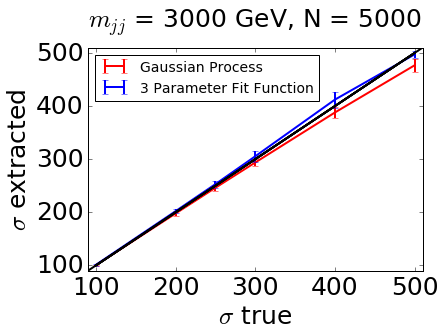

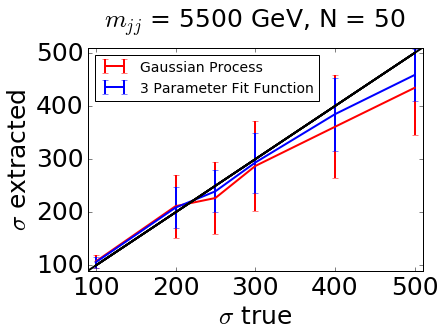

In [43]:
sortMass2 = sorted(massDict_2.keys())

for m in sortMass2:
    wparamSets = [500,400,300,250,200,100]
    N = massDict_2[m]

    plt.figure()
    plt.title(r"$m_{jj}$ = " + str(m) + " GeV, N = "+str(N), fontsize=25,y=1.07)
    plt.errorbar(wparamSets,[listGP_paramW_dict_2[m][i][0] for i in range(len(wparamSets))],yerr = [listGP_paramW_dict_2[m][i][1] for i in range(len(wparamSets))],color="r", lw=2,label="Gaussian Process")
    plt.errorbar(wparamSets,[listSTD_paramW_dict_2[m][i][0] for i in range(len(wparamSets))],yerr = [listSTD_paramW_dict_2[m][i][1] for i in range(len(wparamSets))],color="b",lw=2, label="3 Parameter Fit Function")
    plt.plot([0]+wparamSets+[600], [0]+wparamSets+[600], ls='-', lw=2, color='black')
    plt.xlabel(r'$\sigma$ true', fontsize=25)
    plt.ylabel(r'$\sigma$ extracted', fontsize=25)
    plt.xlim([90, 510])
    plt.ylim([90, 510])
    plt.legend(loc=2, prop={'size':14})
    plt.tick_params(axis='x', labelsize=25)
    plt.tick_params(axis='y', labelsize=25)



### Keep mean and sigma of Gaussian signals fixed, vary amplitude. Fit all three signal parameters in signal+background fit

In [60]:
massDict = {3000: [5000, 2500, 2000, 1500, 1000, 500],
            5500: [200, 150, 100, 50, 25]}


listSTD_paramN_dict={}
listGP_paramN_dict={}
listSTD_paramM_dict={}
listGP_paramM_dict={}
listSTD_paramW_dict={}
listGP_paramW_dict={}
for m in massDict.keys():
    nparamSets = massDict[m]
    listSTD_param_n=[]
    listGP_param_n=[]
    listSTD_param_m=[]
    listGP_param_m=[]
    listSTD_param_w=[]
    listGP_param_w=[]
    for pSet in nparamSets:
        n = pSet    
        w = 250

        listSTD_paramToy_n=[]
        listGP_paramToy_n=[]
        listSTD_paramToy_m=[]
        listGP_paramToy_m=[]
        listSTD_paramToy_w=[]
        listGP_paramToy_w=[]
        
        for itoy, toy in enumerate(toyList[:100]): 
            if itoy%10 ==0: print itoy
            ytoy, xtoy, xtoyerr = removeZeros(toy)
            signalTemplate = sig_model(xtoy, n, m, w, xtoyerr)
            signalTemplate = np.random.poisson(np.around(signalTemplate))
            ydata = ytoy + signalTemplate
            signalTemplateO = sig_model(xvalO, n, m, w, xerrO)
            signalTemplateO = np.random.poisson(np.around(signalTemplateO))
            ydataO = toy + signalTemplateO
        
            #################################
            lnProb = logLike_3ff_fitsig(xvalO,ydataO,xerrO)
            bestval, best_fit_new = fit_3ff_fitsig(lnProb, False)
            a1, a2, a3, Nff, Mff, Wff = best_fit_new

            listSTD_paramToy_n.append(Nff)
            listSTD_paramToy_m.append(Mff)
            listSTD_paramToy_w.append(Wff)
            #########################################

            if itoy%50:
                label="Fit Function bkg+signal: N="+str(n)+" m="+str(m)+" width="+str(w) + "\n Fit params: N="+str(round(Nff,1))+" m="+str(round(Mff,1))+" width="+str(round(Wff,1))
                makePrettyPlots_signal(xvalO, ydataO, bkg2, bkgsig, label)
    
            lnProb = logLike_gp_sig_fixedH(xtoy,ydata, xtoyerr)
            bestval, best_fit = fit_gp_sig_fixedH_minuit(lnProb, False)
    
            N, M, W = best_fit

            listGP_paramToy_n.append(N)
            listGP_paramToy_m.append(M)
            listGP_paramToy_w.append(W)


        listSTD_param_n.append([np.mean(listSTD_paramToy_n, axis=0), np.var(listSTD_paramToy_n, axis=0)])
        listGP_param_n.append([np.mean(listGP_paramToy_n, axis=0), np.var(listGP_paramToy_n, axis=0)])
        listSTD_param_m.append([np.mean(listSTD_paramToy_m, axis=0), np.var(listSTD_paramToy_m, axis=0)])
        listGP_param_m.append([np.mean(listGP_paramToy_m, axis=0), np.var(listGP_paramToy_m, axis=0)])
        listSTD_param_w.append([np.mean(listSTD_paramToy_w, axis=0), np.var(listSTD_paramToy_w, axis=0)])
        listGP_param_w.append([np.mean(listGP_paramToy_w, axis=0), np.var(listGP_paramToy_w, axis=0)])
        

    listSTD_paramN_dict[m] = listSTD_param_n
    listGP_paramN_dict[m] = listGP_param_n
    listSTD_paramM_dict[m] = listSTD_param_m
    listGP_paramM_dict[m] = listGP_param_m
    listSTD_paramW_dict[m] = listSTD_param_w
    listGP_paramW_dict[m] = listGP_param_w

print "I'm done"


0
10
20
30
40
50
60
70


/Users/MeghanFrate/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:42: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
       p0 = nan
       p1 = nan
       p2 = nan
      Num = nan
       mu = nan
    sigma = nan



80
90
{5500: [[103.09632786806729, 105.82988383949801]]}
I'm done


### Save or load (if previously saved) signal parameters

In [28]:
massDict = {3000: 5000,
            5500: 50}


listSTD_paramN_dict={}
listGP_paramN_dict={}
listSTD_paramM_dict={}
listGP_paramM_dict={}
listSTD_paramW_dict={}
listGP_paramW_dict={}

for m in massDict.keys():
    '''
    np.save("newoutputs/STD_paramN_varyN_"+str(m), listSTD_paramN_dict[m])
    np.save("newoutputs/STD_paramM_varyN_"+str(m), listSTD_paramM_dict[m])
    np.save("newoutputs/STD_paramW_varyN_"+str(m), listSTD_paramW_dict[m])
    np.save("newoutputs/GP_paramN_varyN_"+str(m), listGP_paramN_dict[m])
    np.save("newoutputs/GP_paramM_varyN_"+str(m), listGP_paramM_dict[m])
    np.save("newoutputs/GP_paramW_varyN_"+str(m), listGP_paramW_dict[m])
    '''


    listSTD_paramN_dict[m] = np.load("newoutputs/STD_paramN_varyN_"+str(m)+".npy")
    listSTD_paramM_dict[m] = np.load("newoutputs/STD_paramM_varyN_"+str(m)+".npy")
    listSTD_paramW_dict[m] = np.load("newoutputs/STD_paramW_varyN_"+str(m)+".npy")
    listGP_paramN_dict[m] = np.load("newoutputs/GP_paramN_varyN_"+str(m)+".npy")
    listGP_paramM_dict[m] = np.load("newoutputs/GP_paramM_varyN_"+str(m)+".npy")
    listGP_paramW_dict[m] = np.load("newoutputs/GP_paramW_varyN_"+str(m)+".npy")


### Plot mean and standard deviation of amplitude of all fits

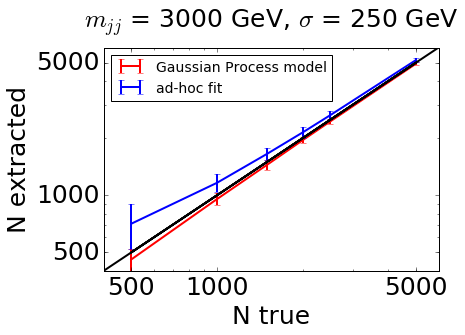

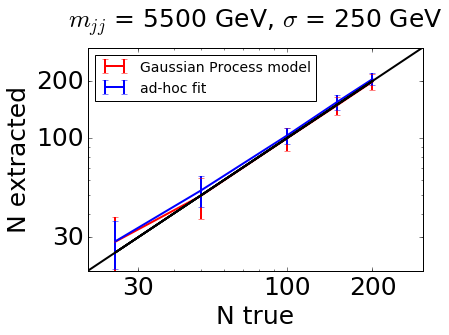

In [42]:
massDict = {3000: [5000, 2500, 2000, 1500, 1000, 500], 
            5500: [200, 150, 100, 50, 25]}


sortMass = sorted(massDict.keys())

for m in sortMass:
    nparamSets = massDict[m]

    f, ax1 = plt.subplots()
    ax1.set_title(r"$m_{jj}$ = " + str(m) + " GeV, $\sigma$ = 250 GeV", fontsize=25, y=1.07)
    ax1.errorbar(nparamSets,[listGP_paramN_dict[m][i][0] for i in range(len(nparamSets))],yerr = np.sqrt([listGP_paramN_dict[m][i][1] for i in range(len(nparamSets))]),color="r", lw=2, label="Gaussian Process model")
    ax1.errorbar(nparamSets,[listSTD_paramN_dict[m][i][0] for i in range(len(nparamSets))],yerr = np.sqrt([listSTD_paramN_dict[m][i][1] for i in range(len(nparamSets))]),color="b", lw=2, label="ad-hoc fit")
    ax1.plot([0]+nparamSets+[1e4], [0]+nparamSets+[1e4], ls='-', lw=2, color='black')
    ax1.set_xlabel('N true', fontsize=25)
    ax1.set_ylabel('N extracted', fontsize=25)
    ax1.tick_params(axis='x', labelsize=25)
    ax1.tick_params(axis='y', labelsize=25)
    ax1.set_xlim([nparamSets[-1]*.25, nparamSets[0]*1.1])
    ax1.set_xscale('log')
    ax1.set_yscale('log')
    if m == 3000:
        ax1.set_xlim([400,6000])
        ax1.set_ylim([400,6000])
        ax1.set_xticks([500, 1000, 5000])
        ax1.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
        ax1.set_yticks([500, 1000, 5000])
        ax1.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    
    else:
        ax1.set_xlim([20,300])
        ax1.set_ylim([20,300])
        ax1.set_xticks([30, 100, 200])
        ax1.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
        ax1.set_yticks([30, 100, 200])
        ax1.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    plt.legend(loc=2, prop={'size':14})
    